In [1]:
%matplotlib inline

/Users/NIGG/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/NIGG/.matplotlib/matplotlibrc", line #515
  (fname, cnt))
/Users/NIGG/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/NIGG/.matplotlib/matplotlibrc", line #516
  (fname, cnt))


In [2]:
import numpy as np
import pandas as pd

#　統計用ツール
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from patsy import dmatrices

#　自作の空間統計用ツール
from spatialstat import *

#描画
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
import seaborn as sns
sns.set(font=['IPAmincho'])

#深層学習
import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

import pyper

### 変数名とデータの内容メモ
	CENSUS: 市区町村コード(9桁)
	P:      成約価格
	S:      専有面積
	L:      土地面積
	R:      部屋数
	RW:     前面道路幅員
	CY:     建築年
	A:      建築後年数(成約時)
	TS:     最寄駅までの距離
	TT:     東京駅までの時間
	ACC:    ターミナル駅までの時間
	WOOD:   木造ダミー
	SOUTH:  南向きダミー
	RSD:    住居系地域ダミー
	CMD:    商業系地域ダミー
	IDD:    工業系地域ダミー
	FAR:    建ぺい率
	FLR:    容積率
	TDQ:    成約時点(四半期)
	X:      緯度
	Y:      経度
	CITY_CODE: 市区町村コード(5桁)
	CITY_NAME: 市区町村名
	BLOCK:     地域ブロック名

In [9]:
data = pd.read_csv("TokyoSingle.csv")
data = data.dropna()
CITY_NAME = data['CITY_CODE'].copy()

In [10]:
CITY_NAME[CITY_NAME == 13101] = '01千代田区'
CITY_NAME[CITY_NAME == 13102] = "02中央区"
CITY_NAME[CITY_NAME == 13103] = "03港区"
CITY_NAME[CITY_NAME == 13104] = "04新宿区"
CITY_NAME[CITY_NAME == 13105] = "05文京区"
CITY_NAME[CITY_NAME == 13106] = "06台東区"
CITY_NAME[CITY_NAME == 13107] = "07墨田区"
CITY_NAME[CITY_NAME == 13108] = "08江東区"
CITY_NAME[CITY_NAME == 13109] = "09品川区"
CITY_NAME[CITY_NAME == 13110] = "10目黒区"
CITY_NAME[CITY_NAME == 13111] = "11大田区"
CITY_NAME[CITY_NAME == 13112] = "12世田谷区"
CITY_NAME[CITY_NAME == 13113] = "13渋谷区"
CITY_NAME[CITY_NAME == 13114] = "14中野区"
CITY_NAME[CITY_NAME == 13115] = "15杉並区"
CITY_NAME[CITY_NAME == 13116] = "16豊島区"
CITY_NAME[CITY_NAME == 13117] = "17北区"
CITY_NAME[CITY_NAME == 13118] = "18荒川区"
CITY_NAME[CITY_NAME == 13119] = "19板橋区"
CITY_NAME[CITY_NAME == 13120] = "20練馬区"
CITY_NAME[CITY_NAME == 13121] = "21足立区"
CITY_NAME[CITY_NAME == 13122] = "22葛飾区"
CITY_NAME[CITY_NAME == 13123] = "23江戸川区"

In [11]:
#Make Japanese Block name
BLOCK = data["CITY_CODE"].copy()
BLOCK[BLOCK == 13101] = "01都心・城南"
BLOCK[BLOCK == 13102] = "01都心・城南"
BLOCK[BLOCK == 13103] = "01都心・城南"
BLOCK[BLOCK == 13104] = "01都心・城南"
BLOCK[BLOCK == 13109] = "01都心・城南"
BLOCK[BLOCK == 13110] = "01都心・城南"
BLOCK[BLOCK == 13111] = "01都心・城南"
BLOCK[BLOCK == 13112] = "01都心・城南"
BLOCK[BLOCK == 13113] = "01都心・城南"
BLOCK[BLOCK == 13114] = "02城西・城北"
BLOCK[BLOCK == 13115] = "02城西・城北"
BLOCK[BLOCK == 13105] = "02城西・城北"
BLOCK[BLOCK == 13106] = "02城西・城北"
BLOCK[BLOCK == 13116] = "02城西・城北"
BLOCK[BLOCK == 13117] = "02城西・城北"
BLOCK[BLOCK == 13119] = "02城西・城北"
BLOCK[BLOCK == 13120] = "02城西・城北"
BLOCK[BLOCK == 13107] = "03城東"
BLOCK[BLOCK == 13108] = "03城東"
BLOCK[BLOCK == 13118] = "03城東"
BLOCK[BLOCK == 13121] = "03城東"
BLOCK[BLOCK == 13122] = "03城東"
BLOCK[BLOCK == 13123] = "03城東"

In [12]:
names = list(data.columns) + ['CITY_NAME', 'BLOCK']
data = pd.concat((data, CITY_NAME, BLOCK), axis = 1)
data.columns = names

#### 市区町村別の件数を集計

In [13]:
print(data['CITY_NAME'].value_counts())                       

12世田谷区    12340
20練馬区      9979
15杉並区      8131
11大田区      7052
21足立区      6479
19板橋区      4827
14中野区      3924
10目黒区      3418
22葛飾区      3165
23江戸川区     3156
09品川区      2424
16豊島区      2153
04新宿区      1885
17北区       1799
13渋谷区      1487
05文京区      1242
18荒川区      1005
08江東区       981
03港区        757
07墨田区       725
06台東区       371
02中央区        56
01千代田区       32
Name: CITY_NAME, dtype: int64


In [23]:
vars = ['P', 'S', 'L', 'R', 'RW', 'A', 'TS', 'TT', 'WOOD', 'SOUTH', 'CMD', 'IDD', 'FAR', 'X', 'Y']
eq = fml_build(vars)

y, X = dmatrices(eq, data=data, return_type='dataframe')

CITY_NAME = pd.get_dummies(data['CITY_NAME'])
TDQ = pd.get_dummies(data['TDQ'])

X = pd.concat((X, CITY_NAME, TDQ), axis=1)

datas = pd.concat((y, X), axis=1)
datas = datas[datas['12世田谷区'] == 1][0:5000]

In [24]:
class CAR(Chain):
    def __init__(self, unit1, unit2, unit3, col_num):
        self.unit1 = unit1
        self.unit2 = unit2
        self.unit3 = unit3
        super(CAR, self).__init__(
            l1 = L.Linear(col_num, unit1),
            l2 = L.Linear(self.unit1, self.unit1),
            l3 = L.Linear(self.unit1, self.unit2),
            l4 = L.Linear(self.unit2, self.unit3),
            l5 = L.Linear(self.unit3, self.unit3),
            l6 = L.Linear(self.unit3, 1),
        )
    
    def __call__(self, x, y):
        fv = self.fwd(x, y)
        loss = F.mean_squared_error(fv, y)
        return loss
    
    def fwd(self, x, y):
        h1 = F.sigmoid(self.l1(x))
        h2 = F.sigmoid(self.l2(h1))
        h3 = F.sigmoid(self.l3(h2))
        h4 = F.sigmoid(self.l4(h3))
        h5 = F.sigmoid(self.l5(h4))
        h6 = self.l6(h5)
        return h6

In [75]:
class DLmodel(object):
    def __init__(self, data, vars, bs=200, n=1000):
        self.vars = vars
        eq = fml_build(vars)
        y, X = dmatrices(eq, data=datas, return_type='dataframe')
        self.y_in = y[:-n]
        self.X_in = X[:-n]
        self.y_ex = y[-n:]
        self.X_ex = X[-n:]
        
        self.logy_in = np.log(self.y_in)
        self.logy_ex = np.log(self.y_ex)
        
        self.bs = bs
        
    def DL(self, ite=100, bs=200, add=False):
        y_in = np.array(self.y_in, dtype='float32')       
        X_in = np.array(self.X_in, dtype='float32')

        y = Variable(y_in)
        x = Variable(X_in)

        num, col_num = X_in.shape
        
        if add is False:
            self.model1 = CAR(13, 13, 3, col_num)
            
        optimizer = optimizers.Adam()
        optimizer.setup(self.model1)
        
        loss_val = 100000000

        for j in range(ite + 10000):
            sffindx = np.random.permutation(num)
            for i in range(0, num, bs):
                x = Variable(X_in[sffindx[i:(i+bs) if (i+bs) < num else num]])
                y = Variable(y_in[sffindx[i:(i+bs) if (i+bs) < num else num]])
                self.model1.zerograds()
                loss = self.model1(x, y)
                loss.backward()
                optimizer.update()
            if loss_val >= loss.data:
                loss_val = loss.data
            if j > ite:
                if loss_val >= loss.data:
                    loss_val = loss.data
                    print('epoch:', j)
                    print('train mean loss={}'.format(loss_val))
                    print(' - - - - - - - - - ')
                    break
            if j % 1000 == 0:
                print('epoch:', j)
                print('train mean loss={}'.format(loss_val))
                print(' - - - - - - - - - ')
            
    def predict(self):
        y_ex = np.array(self.y_ex, dtype='float32').reshape(len(self.y_ex))
        
        X_ex = np.array(self.X_ex, dtype='float32')
        X_ex = Variable(X_ex)
        resid_pred =  self.model1.fwd(X_ex, X_ex).data  
        print(resid_pred[:10])
        
        self.pred = resid_pred
        self.error = np.array(y_ex - self.pred.reshape(len(self.pred),))[0]
        
    def compare(self):
        plt.hist(self.error)

In [76]:
vars = ['P', 'S', 'L', 'R', 'RW', 'A', 'TS', 'TT', 'WOOD', 'SOUTH', 'CMD', 'IDD', 'FAR']
#vars += vars + list(TDQ.columns)

In [77]:
model = DLmodel(datas, vars)

In [78]:
model.DL(ite=20000, bs=200)

epoch: 0
train mean loss=56888976.0
 - - - - - - - - - 
epoch: 1000
train mean loss=48387068.0
 - - - - - - - - - 
epoch: 2000
train mean loss=46748284.0
 - - - - - - - - - 
epoch: 3000
train mean loss=44967768.0
 - - - - - - - - - 
epoch: 4000
train mean loss=41678352.0
 - - - - - - - - - 
epoch: 5000
train mean loss=41678352.0
 - - - - - - - - - 
epoch: 6000
train mean loss=41678352.0
 - - - - - - - - - 
epoch: 7000
train mean loss=40469888.0
 - - - - - - - - - 
epoch: 8000
train mean loss=40469888.0
 - - - - - - - - - 
epoch: 9000
train mean loss=38288768.0
 - - - - - - - - - 
epoch: 10000
train mean loss=37253708.0
 - - - - - - - - - 
epoch: 11000
train mean loss=37253708.0
 - - - - - - - - - 
epoch: 12000
train mean loss=37020724.0
 - - - - - - - - - 
epoch: 13000
train mean loss=35186492.0
 - - - - - - - - - 
epoch: 14000
train mean loss=34883460.0
 - - - - - - - - - 
epoch: 15000
train mean loss=33269868.0
 - - - - - - - - - 
epoch: 16000
train mean loss=33269868.0
 - - - - - - 

In [79]:
model.DL(ite=20000, bs=200, add=True)

epoch: 0
train mean loss=22346982.0
 - - - - - - - - - 
epoch: 1000
train mean loss=21413112.0
 - - - - - - - - - 
epoch: 2000
train mean loss=21413112.0
 - - - - - - - - - 
epoch: 3000
train mean loss=20903448.0
 - - - - - - - - - 
epoch: 4000
train mean loss=19988990.0
 - - - - - - - - - 
epoch: 5000
train mean loss=18561308.0
 - - - - - - - - - 
epoch: 6000
train mean loss=18561308.0
 - - - - - - - - - 
epoch: 7000
train mean loss=18013032.0
 - - - - - - - - - 
epoch: 8000
train mean loss=16432581.0
 - - - - - - - - - 
epoch: 9000
train mean loss=16432581.0
 - - - - - - - - - 
epoch: 10000
train mean loss=16432581.0
 - - - - - - - - - 
epoch: 11000
train mean loss=15418825.0
 - - - - - - - - - 
epoch: 12000
train mean loss=15239754.0
 - - - - - - - - - 
epoch: 13000
train mean loss=15239754.0
 - - - - - - - - - 
epoch: 14000
train mean loss=14351450.0
 - - - - - - - - - 
epoch: 15000
train mean loss=14333427.0
 - - - - - - - - - 
epoch: 16000
train mean loss=11407301.0
 - - - - - - 

In [303]:
model.predict()

[[-200.914505  ]
 [ 813.39611816]
 [-176.11975098]
 [  97.72927856]
 [ 813.26416016]
 [ 806.31604004]
 [-188.42362976]
 [-201.4822998 ]
 [  57.99349976]
 [-201.93777466]]


青がOLSの誤差、緑がOLSと深層学習を組み合わせた誤差。

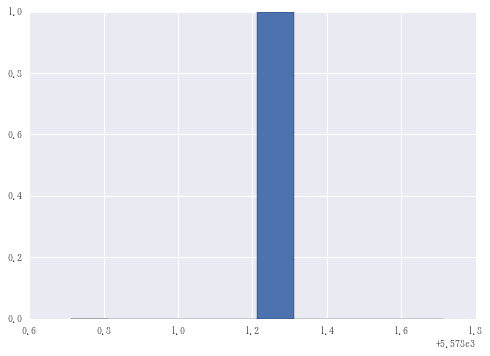

In [51]:
model.compare()

In [52]:
print(np.mean(model.error1))
print(np.mean(model.error2))

AttributeError: 'DLmodel' object has no attribute 'error1'

In [53]:
print(np.mean(np.abs(model.error1)))
print(np.mean(np.abs(model.error2)))

AttributeError: 'DLmodel' object has no attribute 'error1'

In [54]:
print(max(np.abs(model.error1)))
print(max(np.abs(model.error2)))

AttributeError: 'DLmodel' object has no attribute 'error1'

In [55]:
print(np.var(model.error1))
print(np.var(model.error2))

AttributeError: 'DLmodel' object has no attribute 'error1'

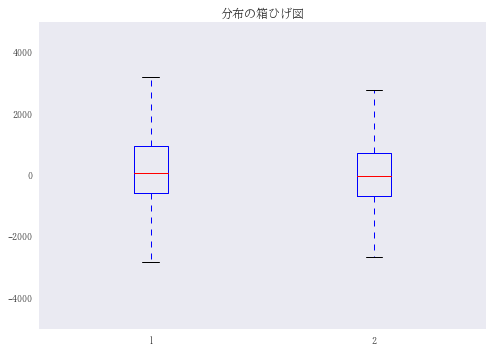

In [316]:
fig = plt.figure()
ax = fig.add_subplot(111)

errors = [model.error1, model.error2]

bp = ax.boxplot(errors)

plt.grid()
plt.ylim([-5000,5000])

plt.title('分布の箱ひげ図')

plt.show()

In [317]:
X = model.X_ex['X'].values
Y = model.X_ex['Y'].values

In [318]:
e = model.error2

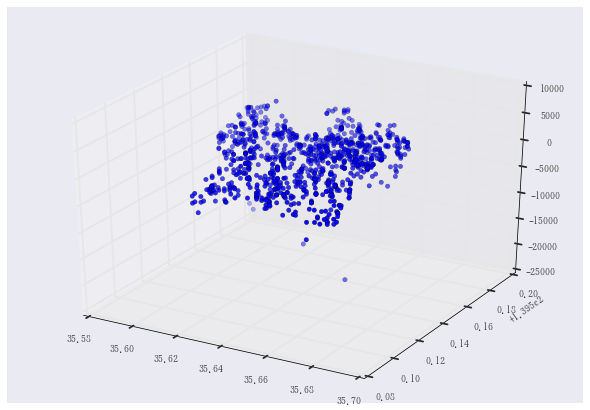

In [319]:
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

fig=plt.figure()
ax=Axes3D(fig)
 
ax.scatter3D(X, Y, e)
plt.show()

array([ 35.66455,  35.65134,  35.63957,  35.60207,  35.66327,  35.65029,
        35.64262,  35.62602,  35.60105,  35.64538,  35.63457,  35.64502,
        35.66455,  35.65314,  35.62616,  35.61948,  35.66079,  35.63714,
        35.65052,  35.65285,  35.66081,  35.65083,  35.65156,  35.62632,
        35.66519,  35.66333,  35.62063,  35.66388,  35.61562,  35.61499,
        35.61528,  35.59893,  35.60094,  35.60108,  35.65905,  35.64066,
        35.6026 ,  35.67156,  35.59519,  35.66376,  35.63561,  35.63352,
        35.66988,  35.65884,  35.67615,  35.64243,  35.64283,  35.65176,
        35.66519,  35.65055,  35.63795,  35.63552,  35.65722,  35.63948,
        35.6573 ,  35.63795,  35.63536,  35.66584,  35.63999,  35.64131,
        35.59604,  35.66175,  35.65339,  35.67573,  35.63049,  35.65297,
        35.62073,  35.65945,  35.64087,  35.63558,  35.65117,  35.65121,
        35.64002,  35.65805,  35.62836,  35.62884,  35.60686,  35.6357 ,
        35.60126,  35.64529,  35.64953,  35.64086, 

In [265]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri



#============
# First plot
#============
# Plot the surface.  The triangles in parameter space determine which x, y, z
# points are connected by an edge.
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_trisurf(X, Y, e)
ax.set_zlim(-1, 1)
plt.show()